<a href="https://colab.research.google.com/github/nabsabraham/cds-eicu/blob/master/1_Connect_BigQuery_explore_patient_table.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Database connection with BigQuery

The aim of this notebook is to get set up with access to the credentialed version of the [eICU Collaborative Research Database](http://eicu-crd.mit.edu/). The database is hosted on Google BigQuery so we will connect with it and query the database. 

We begin by exploring the `patient` table, which contains patient demographics and admission and discharge details for hospital and ICU stays. For more detail, see: http://eicu-crd.mit.edu/eicutables/patient/

## Prerequisites

- Get credentialled access to the eICU database at [PhysioNet](https://physionet.org/content/eicu-crd/2.0/). This process will take a few days. 
- In the mean time, you can simply access the [demo version of eICU](https://physionet.org/content/eicu-crd-demo/2.0/) that does not require you to become an MIT credentialled user. This version has only ~1000 patients. 
- We will query both databases for brevity. 
- Create a Gmail account if you don't have one because the databases are stored on Google BigQuery.

## Load libraries and connect to the data

Run the following cells to import some libraries and then connect to the database.

In [0]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

Before running any queries, you need to first authenticate yourself by running the following cell. If you are running it for the first time, it will ask you to follow a link to log in using your Gmail account, and accept the data access requests to your profile. Once this is done, it will generate a string of verification code, which you should paste back to the cell below and press enter.

In [0]:
auth.authenticate_user()

We'll also set the project id to be our BigQuery project id. 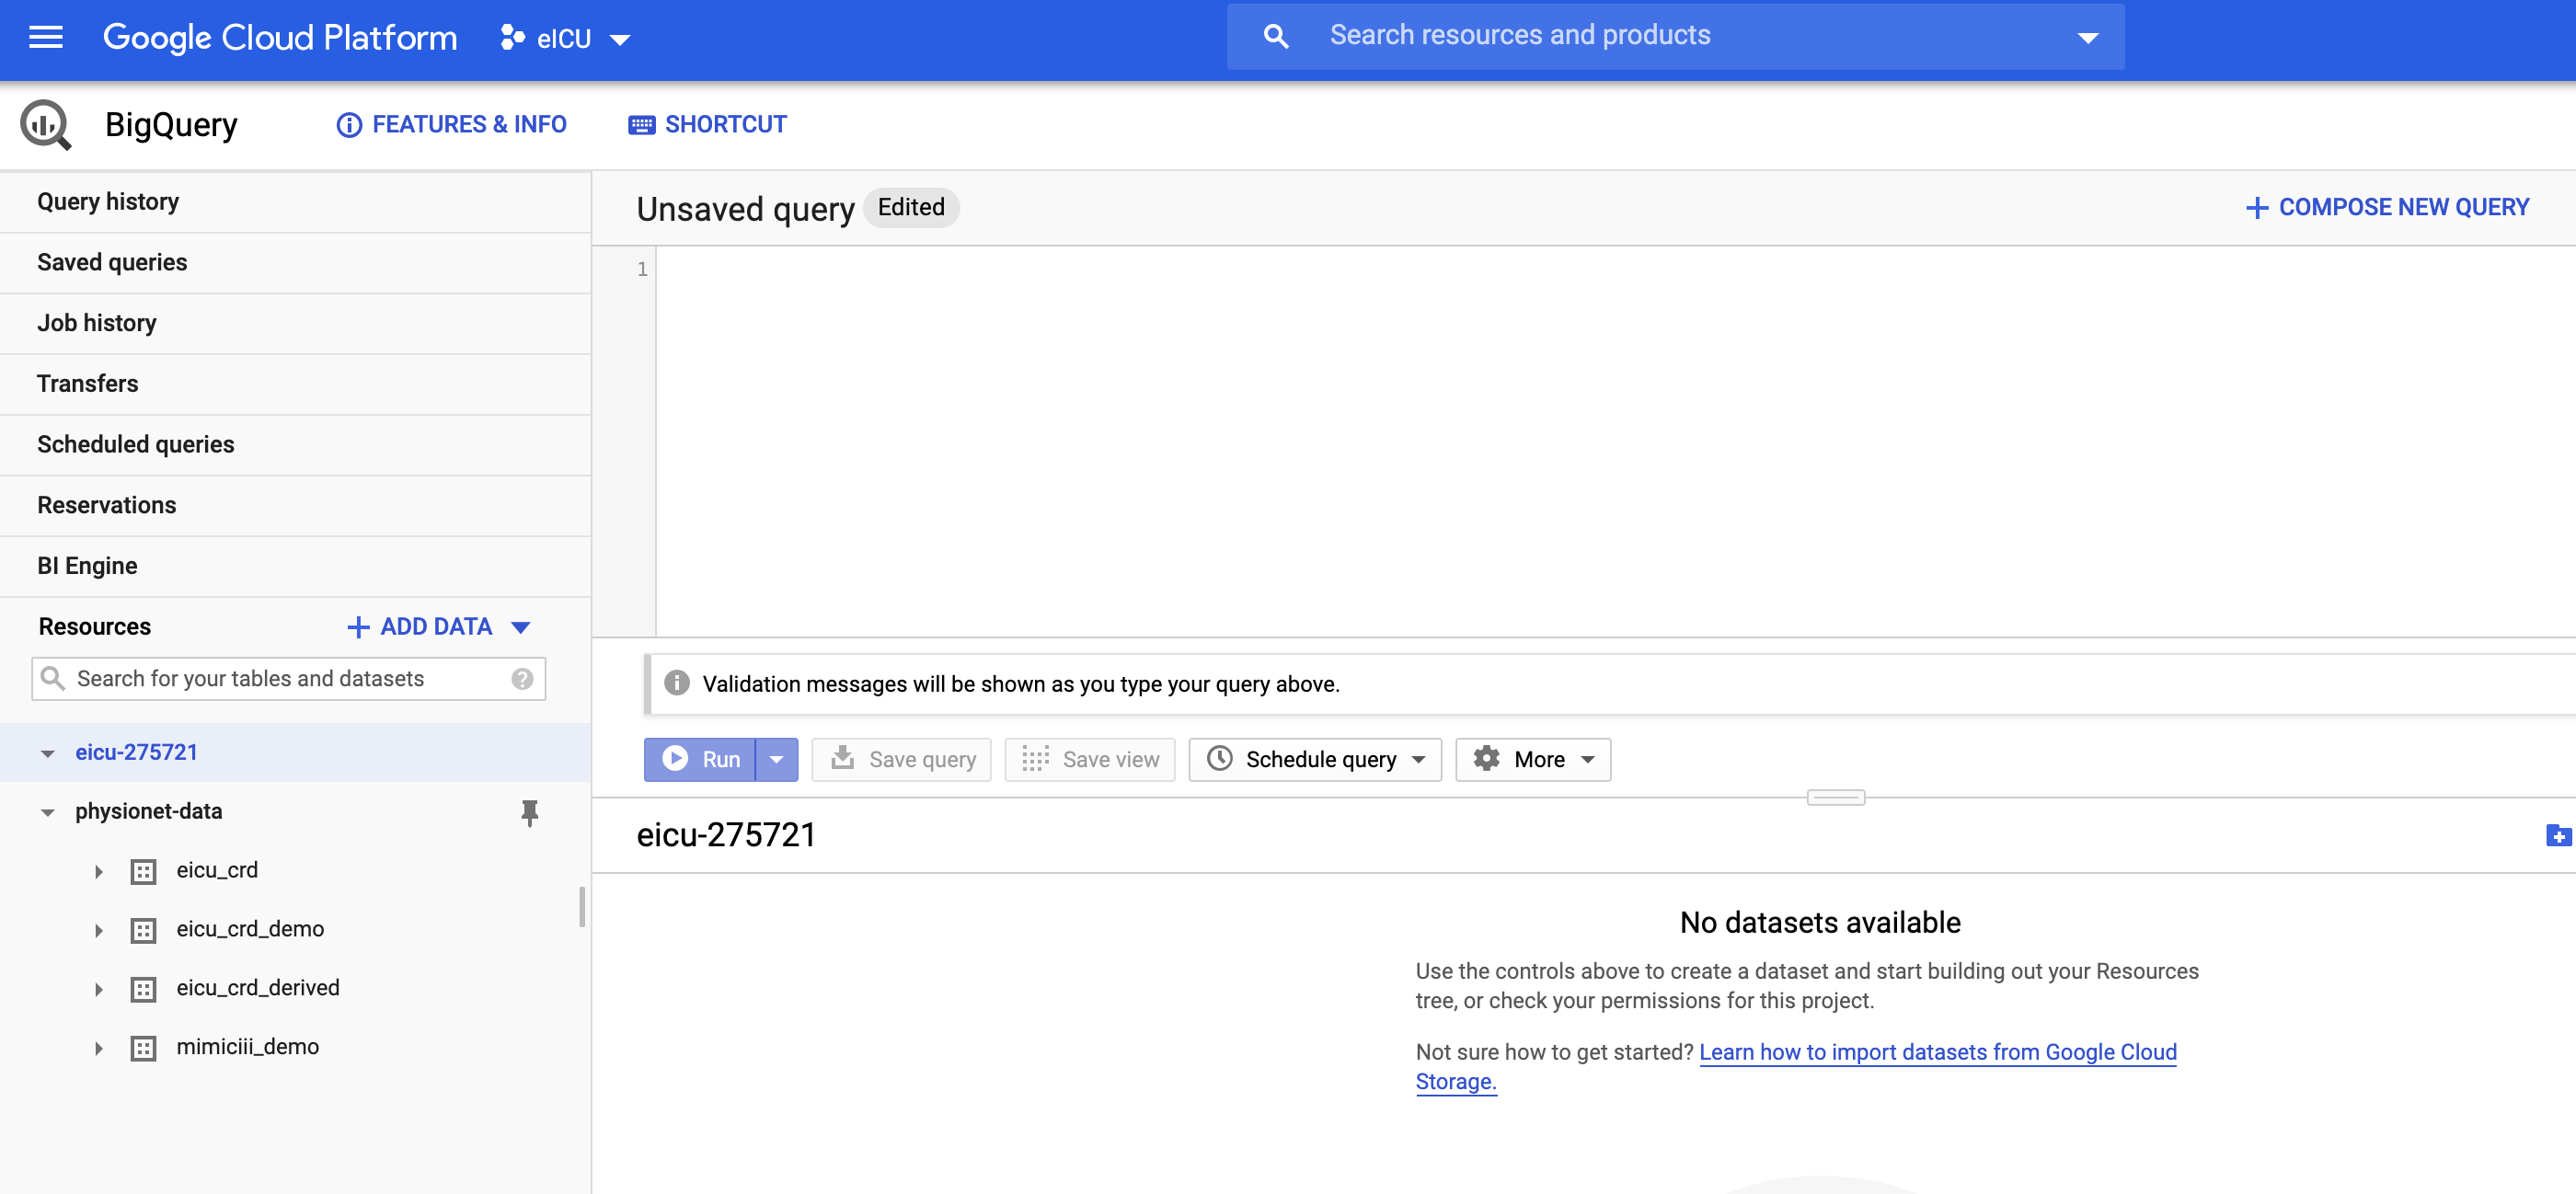


In [0]:
project_id='eicu-275721'
#project_id = 'physionet-data'

# "Querying" our database with SQL

Now we can start exploring the data. We'll begin by running a simple query to load all columns of the `patient` table to a Pandas DataFrame. The query is written in SQL, a common language for extracting data from databases. The structure of an SQL query is:

```sql
SELECT <columns>
FROM <table>
WHERE <criteria, optional>
```

`*` is a wildcard that indicates all columns

# BigQuery

Our dataset is stored on BigQuery, Google's database engine. We can run our query on the database using some special ("magic") [BigQuery syntax](https://googleapis.dev/python/bigquery/latest/magics.html).

Let's first ping the demo database that did not require any credentialled access. The database output gets stored in the `patient` variable. 

In [0]:
%%bigquery --project $project_id patient
SELECT *
FROM `physionet-data.eicu_crd_demo.patient`

We can print a quick view of this returned dataframe output and see how many patients it has. Let's use the `head` method to view the first few rows of our data.

In [5]:
print('Number of patients: \n', len(patient))
patient.head()

Number of patients: 
 1447


,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,210014,182373,Male,45,Caucasian,73,89,"Hypertension, uncontrolled (for cerebrovascula...",178.0,13:08:59,-8,,2015,15:00:00,4424,Skilled Nursing Facility,Alive,Neuro ICU,13:16:00,Direct Admit,1,admit,116.0,112.7,15:00:00,4424,Skilled Nursing Facility,Alive,002-10665
1,200026,174624,Male,50,Caucasian,71,87,Ablation or mapping of cardiac conduction pathway,177.8,10:41:00,-311,,2014,18:17:00,1585,Home,Alive,Med-Surg ICU,15:52:00,Operating Room,1,admit,106.1,106.1,17:40:00,1548,Home,Alive,002-10715
2,221131,190993,Male,83,Caucasian,71,87,"Endarterectomy, carotid",175.3,21:43:00,0,,2014,20:00:00,1337,Home,Alive,Med-Surg ICU,21:43:00,Operating Room,1,admit,NaN,72.1,17:46:00,1203,Home,Alive,002-10249
3,221215,191054,Male,49,Caucasian,71,87,"Infarction, acute myocardial (MI)",185.4,03:16:00,-829,,2014,19:46:00,1601,Home,Alive,Med-Surg ICU,17:05:00,Emergency Department,1,admit,145.3,146.6,19:07:00,1562,Home,Alive,002-10627
4,217835,188445,Male,57,Caucasian,73,92,"CABG alone, coronary artery bypass grafting",172.7,01:09:00,-2917,,2014,17:19:00,8133,Home,Alive,CTICU,01:46:00,Operating Room,1,admit,NaN,80.4,08:25:00,4719,Floor,Alive,002-10324


Great! Now let's run this for the actual eICU database! This might take longer because there's a lot more patients. 

In [0]:
%%bigquery --project $project_id patient
SELECT *
FROM `physionet-data.eicu_crd.patient`

In [7]:
print('Number of patients: \n', len(patient))
patient.head()

Number of patients: 
 200859


,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,hospitaladmitsource,hospitaldischargeyear,hospitaldischargetime24,hospitaldischargeoffset,hospitaldischargelocation,hospitaldischargestatus,unittype,unitadmittime24,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,1137569,844848,Female,75,Other/Unknown,208,513,Emphysema/bronchitis,172.7,17:13:00,-36707,Acute Care/Floor,2015,17:51:00,23811,Death,Expired,MICU,05:00:00,,2,readmit,95.7,86.5,15:06:00,9246,Acute Care/Floor,Alive,011-43764
1,3036927,2462651,Male,51,Caucasian,420,1026,"Cardiovascular medical, other",177.8,19:38:00,-240,Emergency Department,2015,22:00:00,14302,Home,Alive,Med-Surg ICU,23:38:00,,1,admit,NaN,NaN,23:38:00,0,Other ICU,Alive,030-57208
2,3058863,2481889,Female,31,Caucasian,420,1026,Diabetic ketoacidosis,162.6,03:29:00,-292,Emergency Department,2015,23:00:00,879,Home,Alive,Med-Surg ICU,08:21:00,,1,admit,NaN,NaN,08:21:00,0,Other ICU,Alive,030-13634
3,3072720,2494105,Male,58,Caucasian,420,1026,,173.0,00:10:00,0,Other Hospital,2015,17:30:00,5360,Home,Alive,Med-Surg ICU,00:10:00,,1,admit,NaN,NaN,00:10:00,0,Other ICU,Alive,030-53536
4,3075429,2496542,Female,68,Caucasian,420,1026,,165.1,22:38:00,-1,Other Hospital,2014,23:05:00,12986,Death,Expired,Med-Surg ICU,22:39:00,,1,admit,NaN,NaN,22:39:00,0,Other ICU,Alive,030-59276


### Observations

Let's view a small subset of the dataset.

In [8]:
# select a limited number of columns to view
columns = ['uniquepid', 'patientunitstayid','gender','age','unitdischargestatus']
patient[columns].head()

,uniquepid,patientunitstayid,gender,age,unitdischargestatus
0,011-43764,1137569,Female,75,Alive
1,030-57208,3036927,Male,51,Alive
2,030-13634,3058863,Female,31,Alive
3,030-53536,3072720,Male,58,Alive
4,030-59276,3075429,Female,68,Alive


What are the only potential discharge statuses that patients can have?

In [9]:
patient['unitdischargestatus'].unique()

array(['Alive', 'Expired', ''], dtype=object)

What are the unique values for age?

In [10]:
age_col = 'age'
patient[age_col].sort_values().unique()

array(['', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '9', '> 89'], dtype=object)

Let's plot a histogram of the ages to view the patient age distribution:

In [11]:
# create a column containing numerical ages (because ages are actually stored as strings to begin with)
# If ‘coerce’, then invalid parsing will be set as NaN
agenum_col = 'age_num'
patient[agenum_col] = pd.to_numeric(patient[age_col], errors='coerce')
patient[agenum_col].sort_values().unique() 

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., nan])

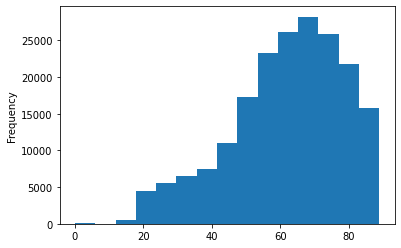

In [12]:
patient[agenum_col].plot(kind='hist', bins=15)

What is the average age of a patient that visits the ICUs?

In [13]:
patient[agenum_col].mean()

62.09524842138959

What are the statistics of the `age_num` column? 

In [14]:
patient['age_num'].describe()

count    193683.000000
mean         62.095248
std          16.685775
min           0.000000
25%          52.000000
50%          64.000000
75%          75.000000
max          89.000000
Name: age_num, dtype: float64